
Bad key animation.mencoder_args in file /Users/jzinn/.config/matplotlib/stylelib/jcz_paper_latex.mplstyle, line 485 ('animation.mencoder_args:          # Additional arguments to pass to mencoder')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution
/Users/jzinn/envs/anaconda/envs/py38/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)
<ipython-input-2-8709d154b55a>:80: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(soln.t, np.sin(soln.t)/soln.t, linestyle='dashed', label='analytic') # the analytic solution for n = 1


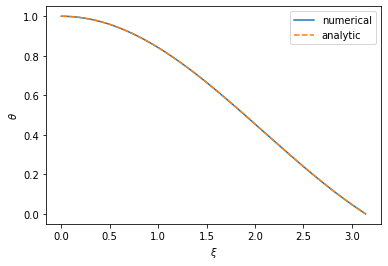

In [2]:
import numpy as np # numpy has various useful functions (e.g., sin(x)), constants (e.g., pi), and data storage routines (e.g., the N-dimentional array: np.array([1,2,3])
from scipy.integrate import solve_ivp # this is the numerical integrator
import pylab as plt # the plotting routines are in plt
# the below will ensure that a call to render the plots with plt.show() will show in the notebook. Otherwise, plt.show() may not result in any image in the notebook.
%matplotlib inline 

# The reformulation of the Lane-Emden equation reads:
# y'' + (2/x)y' + y^n = 0
# where y is theta and x is the re-scaled radius
# n is the polytropic index

# This equation can be re-written in a first-order ODE form:
# dY/dx = A x Y
# where A is a matrix 
# A =     0       1
#     -y^(n-1) -(2/x)
# and Y = y
#         y'

# First-order ODEs like the above can be solved numerically in Python.
# In this case, the boundary conditions are at the center of the star (at x = 0) and we want the solution for the rest of the star.
# This is an initial value problem, then: give a value for Y(x=0) and integrate the above equation outward.
# The solution we want is the first row of Y, which is theta. The second row is the derivative of theta, which we don't care about for now.

def rhs_poly(x, y, n):
    '''
    Returns the RHS of dY/dx = A x Y (i.e., the derivative w.r.t. x of Y)
    
    Inputs
    x : ndarray
     the independent variable (re-scaled radius)
    y : two-element list/ndarray
     the dependent variable, Y (theta and its derivative)
    n : int
     the polytropic index
     
    Outputs
    z : two-element list/ndarray
     the derivative of Y, dY/dx    
    '''
    
    # z is the derivative of Y w.r.t. x and is the output of this function.
    z = [0,0] # the output is a two-element vector, so give the output dummy values for now that will be filled in later.
    
   
    # there is a singularity at 0 so need to explicitly set the derivative of Y to be 0 near x = 0.
    if x < 1e-7:
        z[0] = 0.0
        z[1] = 0.0
    else:
        z[1] = -(y[0]+0j)**(n-1)*y[0] - 2/x*y[1] # derivative of y' (i.e., y'')
        # Exercise 0. (completed in class)
        # Complete the below line --- what is the derivative of the first element in terms of y[0] and y[1]?
        z[0] = 0*y[0] + 1.0*y[1] # derivative of y !!!
    
    return z

y0 = [1.0, 0.0] # the boundary conditions: theta must be 1 at the center of the star by definition so that the density at the center is the central density. the derivative of theta should be zero at the center.
n = 1.0 # set the polytropic index

# solve_ivp documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
# take time to read the documentation to understand the following call.
# Note that we want to integrate n = 1.0 from 0 to pi, since we know the analytic solution in theory has the radius of the star at x=pi.

soln = solve_ivp(rhs_poly, [0, np.pi], y0, method='RK45', max_step=1e-3, args=[n]) # RK45 is a Runge-Kutta integration scheme

# soln.t is the independent variable (i.e., the re-scaled radius)
# soln.y is the dependent variable (i.e., the solution to dY/dx = A x Y --- first row is the solution and second row is its derivative)

plt.plot(soln.t, soln.y[0,:], label='numerical') # the numerical solution for n = 1 (only caring about the first row: B[c,d] is the cth row and dth column; B[c,:] is every column of the cth row.
plt.xlabel(r'$\xi$') # add labels --- the r'$$' format means you can render equations in the plot.
plt.ylabel(r'$\theta$')

# plt.legend() # render the legend
# plt.show()

# Exercise 1. (completed in class)
# Now plot on top of this the analytic solution, giving the label 'analytic', using the numpy function np.sin: https://numpy.org/doc/stable/reference/generated/numpy.sin.html
# Add an appropriate label
plt.plot(soln.t, np.sin(soln.t)/soln.t, linestyle='dashed', label='analytic') # the analytic solution for n = 1
plt.legend()
plt.show()

In [3]:
from scipy import interpolate
# If you wanted to get theta for a particular value of x, you can interpolate the solution. This will come in handy later.
interp = interpolate.UnivariateSpline(soln.t, soln.y[0,:], k=3, s=0, ext=3) # ext = 3 means to return the boundary value when extrapolating beyond the training points

# now you can print the value of theta for any point, x:
print('value of theta at x = 0: {}'.format(interp(0.0)))

# you can confirm that x = pi is where the radius is:
print('value of theta at x = pi: {}'.format(interp(np.pi)))

# which you could also do by using a root-finder:
from scipy.optimize import root_scalar
from scipy import interpolate

Rx = root_scalar(interp, bracket=[0, 6*np.pi]).root
print('x at which theta = 0: {}'.format(Rx))

# although it is not obvious, root_scalar in this case defaults to the 'brentq' method, which is a fancier version of the bisection (method='bisect') method.
# you may try to specify the bisection method instead and will find that it yields the same answer.

value of theta at x = 0: 1.0
value of theta at x = pi: -7.489126506443622e-17
x at which theta = 0: 3.141592653590708


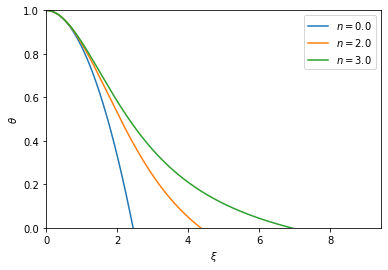

theta at x = 1: 0.8550575685886259


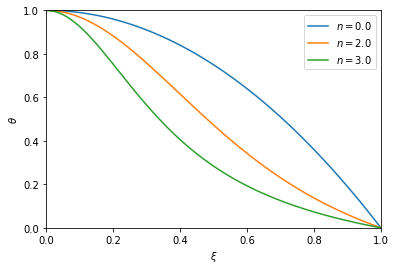

In [4]:
# The below shows the behavior of the Lane-Emden solutions for different n. 
ns = [0.0, 2.0, 3.0]
for n in ns:
    soln = solve_ivp(rhs_poly, [0, np.pi*6.0], y0, method='RK45', max_step=1e-3, args=[n])
    plt.plot(soln.t, soln.y[0,:], label=r'$n = {}$'.format(n))
    plt.ylim([0, 1]) # force the y-axis limits to go from 0 to 1.
    plt.xlim([0,3.0*np.pi]) # make the x-limits 0 and 3pi
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\theta$')
plt.legend() # put the legend on the plot.
plt.show()

# We will use object-oriented programming as we go forward. This involves classes, which are structures that have particular methods (functions) 
class Poly(object):
    '''
    Polytrope class with methods:
    theta(x) : the polytrope solution for re-scaled radius x
    
    Examples
    Pn1 = Poly(n=3)
    Pn1.theta(1.0) # this will give theta at x=1.0.
    '''
    # this __init__() method is called when the class is instantiated (e.g., P = Poly(n=3))
    def __init__(self, n=np.nan):
        self.n = n
        # solve the polytrope
        self.y0 = [1.0, 0.0]
        self.soln = solve_ivp(rhs_poly, [0, np.pi*6.0], self.y0, method='RK45', max_step=1e-3, args=[self.n])
        # define the solution attribute as an interpolation object
        self._theta = interpolate.UnivariateSpline(self.soln.t, self.soln.y[0,:], k=3, s=0, ext=3)
        
    def theta(self, x):
        '''
        Polytrope solution as a function of re-scaled radius, x.
        Inputs
        x : float | ndarray
         re-scaled radius
        Outputs
        theta, the polytrope solution.
        '''
        return self._theta(x)
    
# to use this class, instantiate an instance of it
P = Poly(n=3)
print('theta at x = 1: {}'.format(P.theta(1.0))) # and now theta is a method that can be called like theta(x)

# Exercise 2. (4 points)
#It is not quite fair to compare the solutions as a function of the re-scaled radius, since they have different scale-factors, alpha_n.
#Copy the above for loop and adapt it so that the stellar radius of every solution occurs at x = 1 on the plot, using the Poly class.
#Include a legend with the labels for each line, as well as x- and y-labels.
#Restrict the x-limits and y-limits appropriately 
ns = [0.0, 2.0, 3.0]
for n in ns:
    x = np.linspace(0, 1.0, 100)
    P = Poly(n=n)
    Rx = root_scalar(P.theta, bracket=[0, 6*np.pi]).root
    plt.plot(x, P.theta(x*Rx), label=r'$n = {}$'.format(n))
    plt.ylim([0, 1]) # force the y-axis limits to go from 0 to 1.
    plt.xlim([0, 1]) # force the x-axis limits to go from 0 to 1.
plt.xlabel(r'$r/R$')
plt.ylabel(r'$\theta$')
plt.legend()
plt.show()

In [65]:
from scipy.integrate import quad
from scipy.optimize import root_scalar
from my_routines.const import G, Msun, Rsun, hbar, c, fgamma, mamu, mubar # these are some constants of use
from scipy import interpolate

# It is of interest of course to determine the pressure and density profiles, and not theta.
# We will make a new class that builds on Poly (which has the theta method) that will have new methods

class Poly2(Poly): # this syntax means Poly2 will inherit the methods of Poly (i.e., theta()).
    '''
    A new and improved version of the Poly class, which has the same attributes and methods, plus:
    rhoavg(M, R): the average density of star with mass M and radius R
    rhocen(M, R): the central density of a star of mass M and radius R
    alpha(M, R): the polytropic constant, alpha, for a star of mass M and radius R
    K(M, R): the polytropic constant, K_n, for a star of mass M and radius R
    rho0(x, M, R): the density at re-scaled radius, x, for a star of mass M and radius R
    P0(x, M, R): the pressure at re-scaled radius, x, for a star of mass M and radius R  
    '''
    def __init__(self, n=np.nan):
        # this will call all of the setup for Poly, and therefore Poly2 will inherit Poly's self.n, self.y0, self.soln, and self._theta.
        super(Poly2, self).__init__(n=n)
        # find the root of theta to find the radius of the star in re-scaled radii, x = r*alpha
        self.Rx = root_scalar(self.theta, bracket=[0, 6*np.pi], xtol=1e-10).root
        # use this radius to define theta up to and including Rx.
        self.soln2 = solve_ivp(rhs_poly, [0, self.Rx], self.y0, method='RK45', max_step=1e-3, args=[n])
        self._theta = interpolate.UnivariateSpline(self.soln2.t, self.soln2.y[0,:], k=3, s=0, ext=3)
        
    def rhoavg(self, M, R):
        '''
        Average density of star with mass M and radius R
        Inputs
        M : float
         mass of the star in g
        R : float
         radius of the star in cm
        '''
        return M/(4.*np.pi/3.*R**3)

    # Ecercise 3. (4 points)
    # Find the central density as a function of the total mass of the star, M, and radius, R, and write a function, rhocen(M, R), which returns that value.
    # Hint: begin by showing what the average density is using the equation of conservation of mass
    # You will want to use the integration function, quad, which will evaluate a definite integral between two values for a given integrand function, integrand (see blanks below)
    def rhocen(self, M, R):
        '''
        The central density of a star of mass M and radius R
        Inputs
        M : float
         the mass of the star in g
        R : float
         the radius of the star in cm
        Outputs
        Central density (scalar)
        '''        
        def integrand(x, M, R):
            return self.theta(x)**self.n*x**2
        return self.Rx**3/quad(integrand, 0, self.Rx, args=(M, R))[0]/3.*self.rhoavg(M, R)

    # Exercise 4. (4 points)
    # Add methods for alpha, K, rho0, and P0
    # Plot rho0 for n = 0, 2, 3 for the mass of the Sun and radius of the Sun.
    # Plot P0 for n = 0, 2, 3 for the mass of the Sun and radius of the Sun.
    # (Msun and Rsun are constants that are imported already (in cgs units of g and cm): from my_routines.const import G, Msun, Rsun, hbar, c, fgamma, mamu, mubar.)
    # Hint: What is the pressure profile for n = 0 by solving the Lane-Emden equation by hand? 
    # Update your code accordingly.
    
    def alpha(self, M, R):
        '''
        The polytropic constant, alpha, for a star of mass M and radius R
        Inputs
        M : float
         the mass of the star in g
        R : float
         the radius of the star in cm
        Outputs
        The radius scale factor, such that x = r/alpha
        '''
        return R/self.Rx
    
    def K(self, M, R):
        '''
        The polytropic constant, K_n, for a star of mass M and radius R
        Inputs
        M : float
         the mass of the star in g
        R : float
         the radius of the star in cm
        Outputs
        Polytropic constant, K_n
        '''
        return self.alpha(M, R)**2*4.*np.pi*G*self.rhocen(M, R)**(1.-1./self.n)/(self.n+1)

    def rho0(self, x, M, R):
        '''
        The density at re-scaled radius, x, for a star of mass M and radius R
        Inputs
        x : ndarray or float
         re-scale radial coordinate, xi
        M : float
         stellar mass in g
        R : float
         stellar radius in cm
        Outputs
        ndarray or float
         density at re-scaled radial coordinate, xi
        '''
        return self.theta(x)**self.n*self.rhocen(M, R)

    def P0(self, x, M, R):
        '''
        The pressure at re-scaled radius, x, for a star of mass M and radius R
        Inputs
        x : ndarray or float
         re-scaled radial coordinate, xi
        M : float
         stellar mass in g
        R : float
         stellar radius in cm
        Outputs
        ndarray or float
         pressure at re-scaled radial coordinate, xi
        '''
        if self.n == 0:
            return self.alpha(M, R)**2*self.rhocen(M, R)**2*4.*np.pi*G*(1 - 1./6*x**2)
            #return 3./8./np.pi*G*M**2/R**4*(1 - 1./6*x**2) # you could have solved dP/dr = -g rho directly for rho = constant to get this version.
        return self.K(M, R)*self.rho0(x, M, R)**(1.+1./self.n)
    

2.449489742783174
4.3528745959461785
6.896848619376933


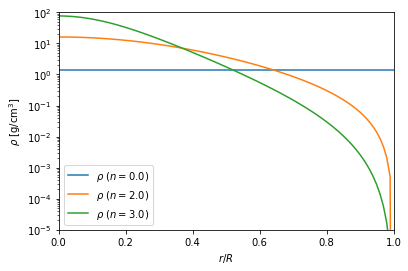

In [50]:

# we don't need to update anything about the solution for plotting rho for n = 0...
ns = [0.0, 2.0, 3.0]
for n in ns:
    x = np.linspace(0, 1.0, 100)
    P = Poly2(n=n)
    plt.plot(x, P.rho0(x*P.Rx, Msun*1e-3, Rsun), label=r'$\rho\ (n = {})$'.format(n)) # using Msun*1e-3 because Msun is actually in kg not g so converting to g.

plt.ylim([1e-5, 1e2]) # choose a suitable y-axis range to better see the behavior
plt.xlim([0, 1])
plt.xlabel(r'$r/R$')
plt.ylabel(r'$\rho\ [\mathrm{g}/\mathrm{cm}^3]$')
plt.yscale('log')
plt.legend()
plt.show()

<ipython-input-63-72216b0ab87c>:106: RuntimeWarning: invalid value encountered in sqrt
  return self.theta(x)**self.n*self.rhocen(M, R)
<ipython-input-63-72216b0ab87c>:127: RuntimeWarning: invalid value encountered in power
  return self.K(M, R)*self.rho0(x, M, R)**(1.+1./self.n)


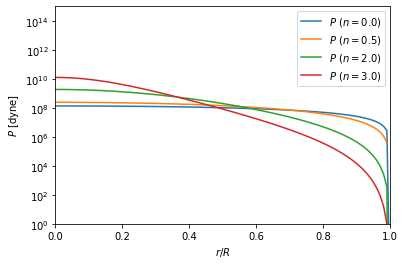

In [64]:
# to plot P
plt.clf()
# we can try a number for n close to 0 for plotting the numerical solution, but exactly 0 will not work.
ns = [0.0, 0.5, 2.0, 3.0]
for n in ns:
    x = np.linspace(0, 1.0, 100)
    P = Poly2(n=n)
    plt.plot(x, P.P0(x*P.Rx, Msun*1e-3, Rsun), label=r'$P\ (n = {})$'.format(n)) # using Msun*1e-3 because Msun is actually in kg not g so converting to g.
  
plt.ylim([1e0, 1e15]) # choose a suitable y-axis range to better see the behavior
plt.xlim([0, 1])
plt.xlabel(r'$r/R$')
plt.ylabel(r'$P\ [\mathrm{dyne}]$')
plt.yscale('log')
plt.legend()
plt.show()